In [1]:
!pip -q install transformers==4.49.0 accelerate>=0.26.0 diffusers==0.32.2 pillow==11.0.0


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from diffusers import StableDiffusionXLPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPImageProcessor, CLIPTokenizer, CLIPModel
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch
import torch.nn as nn
from PIL import Image as PIL_Image
from IPython.display import display

### Load the model

In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
dtype=torch.float16

feature_extractor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
safety_checker = StableDiffusionSafetyChecker.from_pretrained(
    "CompVis/stable-diffusion-safety-checker").to(device)

### Define the embedding update function 

Here we define the function that allows us to add arbitrary images as a nsfw category. By adding an image as a nsfw category we will start classifying it and all similar images as nsfw.

In [4]:
def add_nsfw_embedding(image: PIL_Image, weight: int):
    safety_checker_input = feature_extractor(image, return_tensors="pt").to(device)

    pooled_output  = safety_checker.vision_model(safety_checker_input.pixel_values.to(dtype))[1]
    image_embeds = safety_checker.visual_projection(pooled_output)
    
    safety_checker.concept_embeds = nn.Parameter(torch.cat([safety_checker.concept_embeds, image_embeds]))
    safety_checker.concept_embeds_weights = nn.Parameter(torch.cat([safety_checker.concept_embeds_weights, torch.Tensor([0.6]).to(device)]))

    print(f"{image.filename} has been added to the NSFW categories")

### Define our predict function

This predicts if our image is nsfw or not. It returns `True` if it's nsfw and `False` otherwise.

In [5]:
def do_safety_check(image):
    safety_checker_input = feature_extractor(image, return_tensors="pt").to(device)
    image, has_nsfw_concept = safety_checker(
        images=pil_to_tensor(image).unsqueeze(0), clip_input=safety_checker_input.pixel_values.to(dtype)
        )
    
    return has_nsfw_concept

## Let's try the model

We can run a nsfw check against a green fedora:

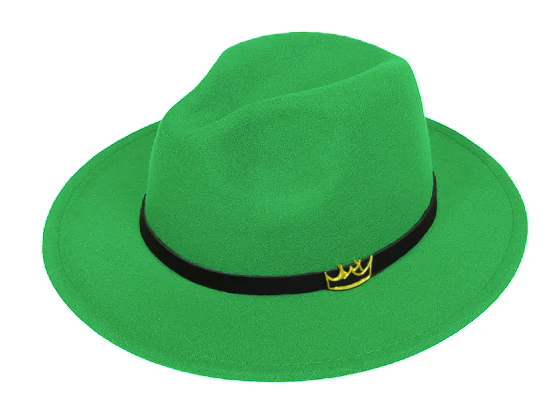

[False]
The image was predicted as safe


In [ ]:
image = PIL_Image.open("images/green-fedora-2.png")
display(image)
prediction = do_safety_check(image)
print(prediction)
print(f"The image was predicted as {'NSFW' if prediction[0] else 'safe'}")

Then we decide that we don't want to allow green fedoras, so we take another green fedora and add it as a nsfw category:

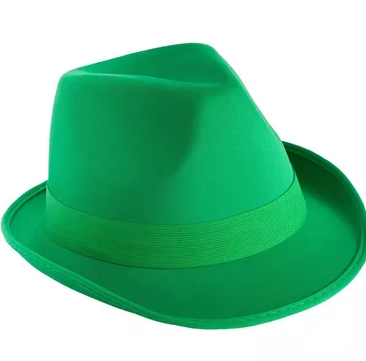

/opt/app-root/src/green-fedora.png has been added to the NSFW categories


In [ ]:
# Image we don't want to allow
image_to_ban = PIL_Image.open("images/green-fedora.png")
display(image_to_ban)
add_nsfw_embedding(image_to_ban, 0.6)

When we try with the first green fedora again, we can now see how it's now a nsfw image:

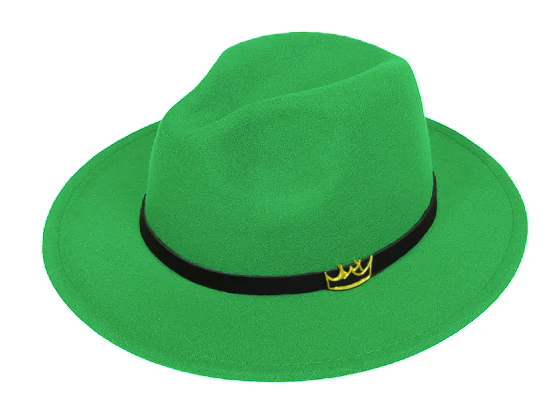

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


[True]
The image was predicted as NSFW


In [ ]:
image = PIL_Image.open("images/green-fedora-2.png")
display(image)
prediction = do_safety_check(image)
print(prediction)
print(f"The image was predicted as {'NSFW' if prediction[0] else 'safe'}")

And just to make sure we didn't make all images nsfw, we try with a cute kitten and find that cute kittens still are allowed by our model:

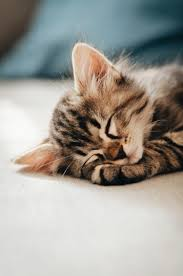

[False]
The image was predicted as safe


In [ ]:
image = PIL_Image.open("images/cute-cat.jpg")
display(image)
prediction = do_safety_check(image)
print(prediction)
print(f"The image was predicted as {'NSFW' if prediction[0] else 'safe'}")